## Import Modules

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

## Load the Dataset

In [31]:
TRAIN_DIR = '../facial_expression/dataset/train/train/'
TEST_DIR = '../facial_expression/dataset/test/test/'

In [32]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [33]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,../facial_expression/dataset/train/train/fear\...,fear
1,../facial_expression/dataset/train/train/happy...,happy
2,../facial_expression/dataset/train/train/neutr...,neutral
3,../facial_expression/dataset/train/train/neutr...,neutral
4,../facial_expression/dataset/train/train/happy...,happy


In [34]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

angry Completed
disgust Completed
fear Completed
happy Completed
neutral Completed
sad Completed
surprise Completed


,image,label
0,../facial_expression/dataset/test/test/angry\P...,angry
1,../facial_expression/dataset/test/test/angry\P...,angry
2,../facial_expression/dataset/test/test/angry\P...,angry
3,../facial_expression/dataset/test/test/angry\P...,angry
4,../facial_expression/dataset/test/test/angry\P...,angry


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

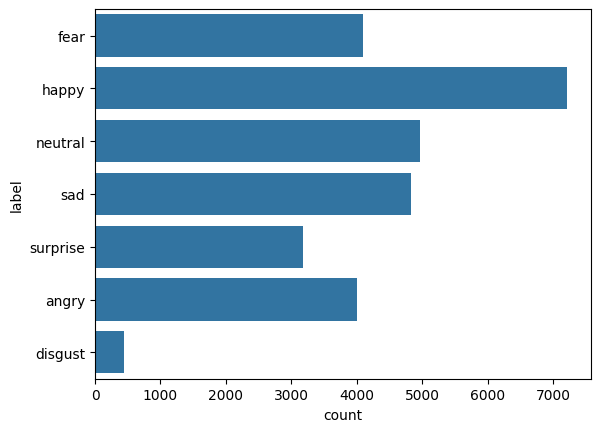

In [35]:
sns.countplot(train['label'])

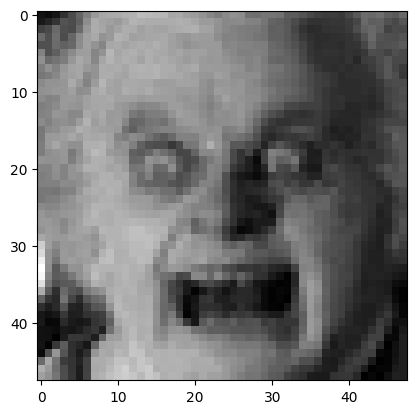

In [36]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

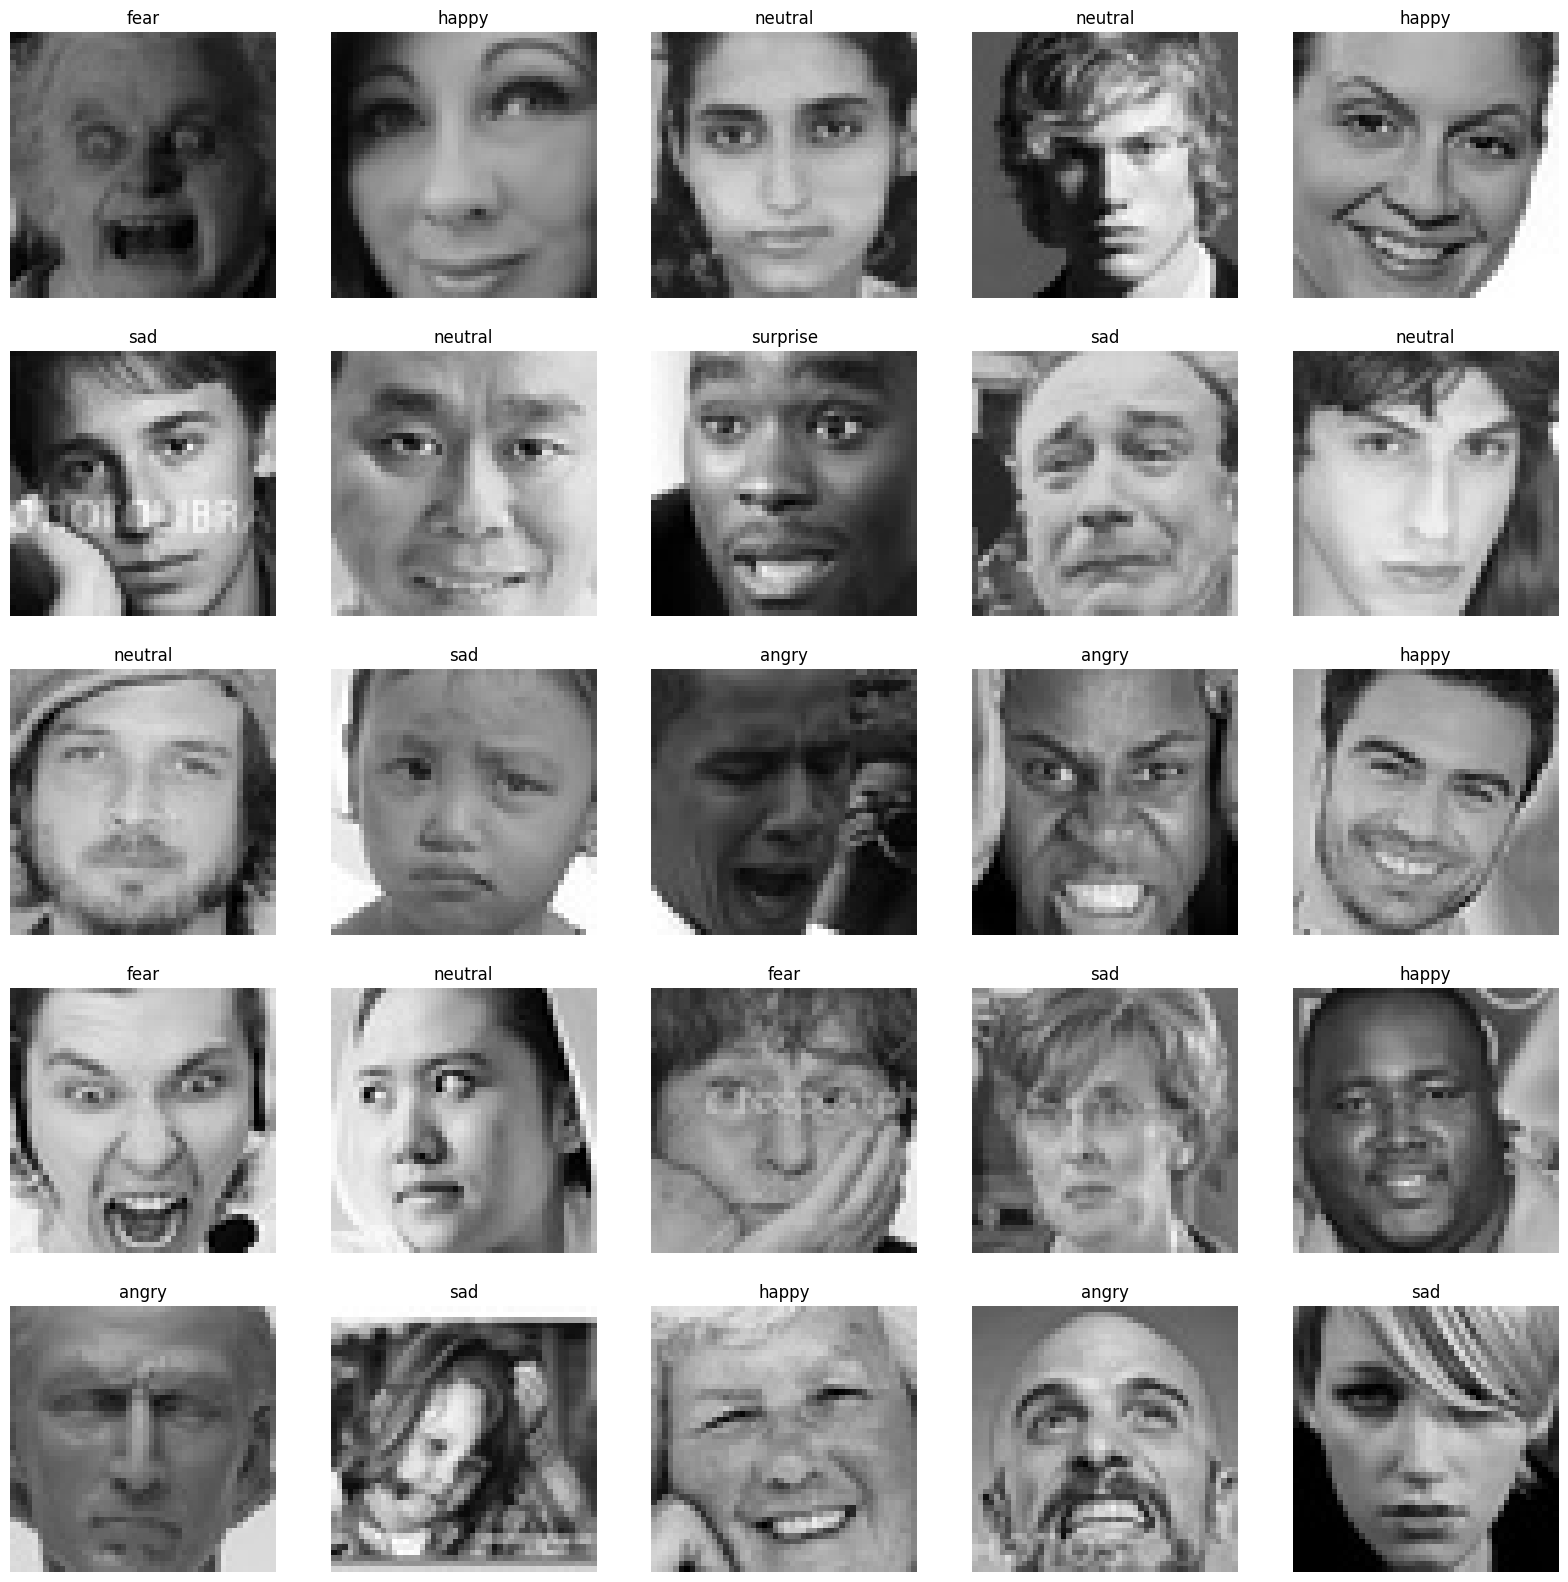

In [37]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [38]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        # Load the image in grayscale mode
        img = load_img(image, color_mode='grayscale', target_size=(48, 48))  # Ensure size is consistent
        img_array = np.array(img)  # Convert to a NumPy array
        features.append(img_array)
    
    # Convert the list of features to a NumPy array
    features = np.array(features, dtype='float32')
    
    # Reshape to match the input dimensions required by the model
    features = features.reshape(len(features), 48, 48, 1)
    
    return features

In [39]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [40]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [41]:

## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [42]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [43]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [44]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.])

In [45]:
# config
input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [46]:
model = Sequential()
# Convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# Output layer
model.add(Dense(output_class, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])  # Wrap 'accuracy' in a list


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with fewer epochs and smaller batch size
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,  # Smaller batch size
    epochs=20,  # Fewer epochs
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]  # Stop early if no improvement
)


Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 270s 598ms/step - accuracy: 0.2457 - loss: 1.8345 - val_accuracy: 0.2505 - val_loss: 1.8100
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 270s 601ms/step - accuracy: 0.2498 - loss: 1.7961 - val_accuracy: 0.2916 - val_loss: 1.7121
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 272s 605ms/step - accuracy: 0.2955 - loss: 1.7163 - val_accuracy: 0.3773 - val_loss: 1.6023
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 239s 531ms/step - accuracy: 0.3545 - loss: 1.6291 - val_accuracy: 0.4196 - val_loss: 1.4724
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 383s 853ms/step - accuracy: 0.3925 - loss: 1.5527 - val_accuracy: 0.4334 - val_loss: 1.4211
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 342s 762ms/step - accuracy: 0.4147 - loss: 1.5028 - val_accuracy: 0.4597 - val_loss: 1.3677
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 308s 685ms/step - accuracy: 0.4467 - loss: 1.4396 - val_accuracy: 0.4932 - val_loss: 1.3238
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 366s 816ms/step - accuracy: 0.4490 -

## Plot the Results

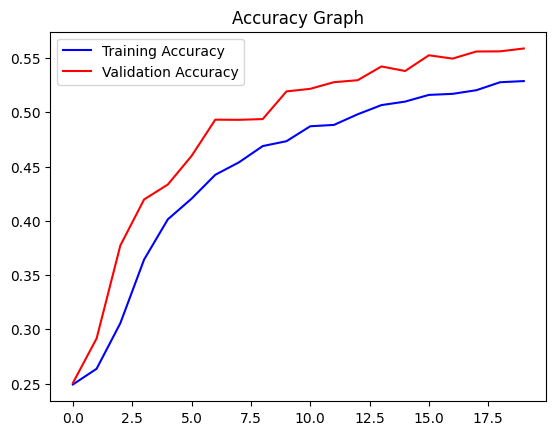

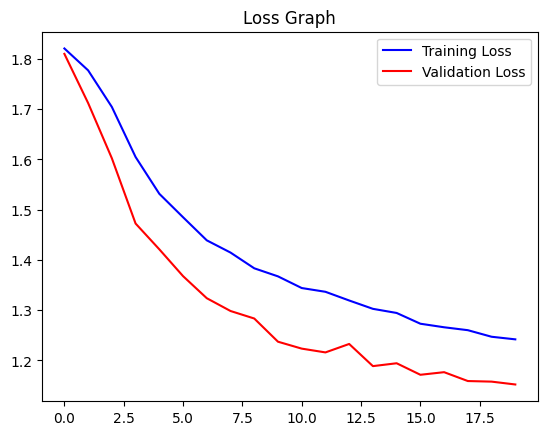

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Predicted Output: angry


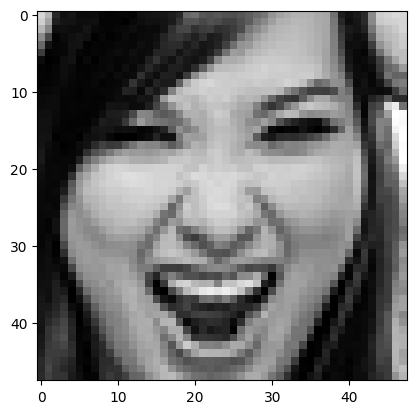

In [49]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Output: happy


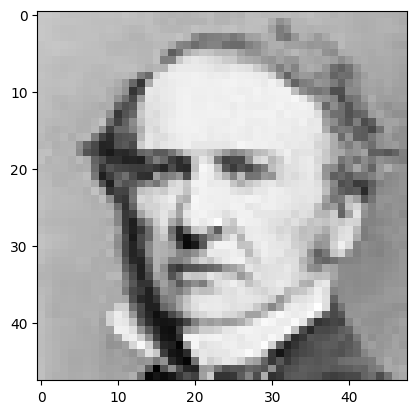

In [50]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Output: happy


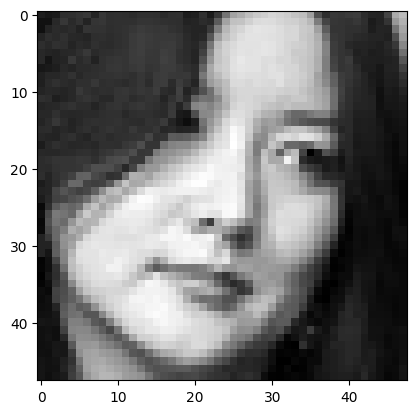

In [51]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');